In [1]:
import torch
import numpy as np

from cognitive_modeling.models.utility_models import u_pow, u_lin
from simulation.cpc_like import generate_data_cpc_like
from cognitive_modeling.cpc_like import fit_cpc_like
from discrepancy_modeling.discrepancy_modeling import DiscrepancyModel

import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
%config InlineBackend.figure_format = "retina"
sns.set_context("paper")

In [39]:
u_truth = u_pow
tau_truth = 100
theta_truth = 0.5
n = 200

print("generating data...")
data = generate_data_cpc_like(u=u_truth, tau=tau_truth, theta=theta_truth, n=n)

print("fitting data...")
opt_param = fit_cpc_like(data, u=u_truth, w=None)
tau = opt_param[0]
theta = opt_param[1]
print("tau", tau, "theta_u", theta)

generating data...
fitting data...
tau 115.55567565183459 theta_u 0.45487383253618446


In [37]:
h_set = "sigmoid", "exp", "identity"
u_set = u_pow, u_lin

In [7]:
discrepancy_models = {}

for h in h_set:
    for u in u_set:

        dm = DiscrepancyModel(
            data=data,
            u=u,
            theta=theta, tau=tau,  h=h, n_samples=100,
            learn_inducing_locations=False, n_inducing_points=50)

        dm.train(epochs=300)

        discrepancy_models[(u.__name__, h)] = dm

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [32]:
for u_idx, u in enumerate(u_set):
        
    print((u_idx*2) // 2)

0
1


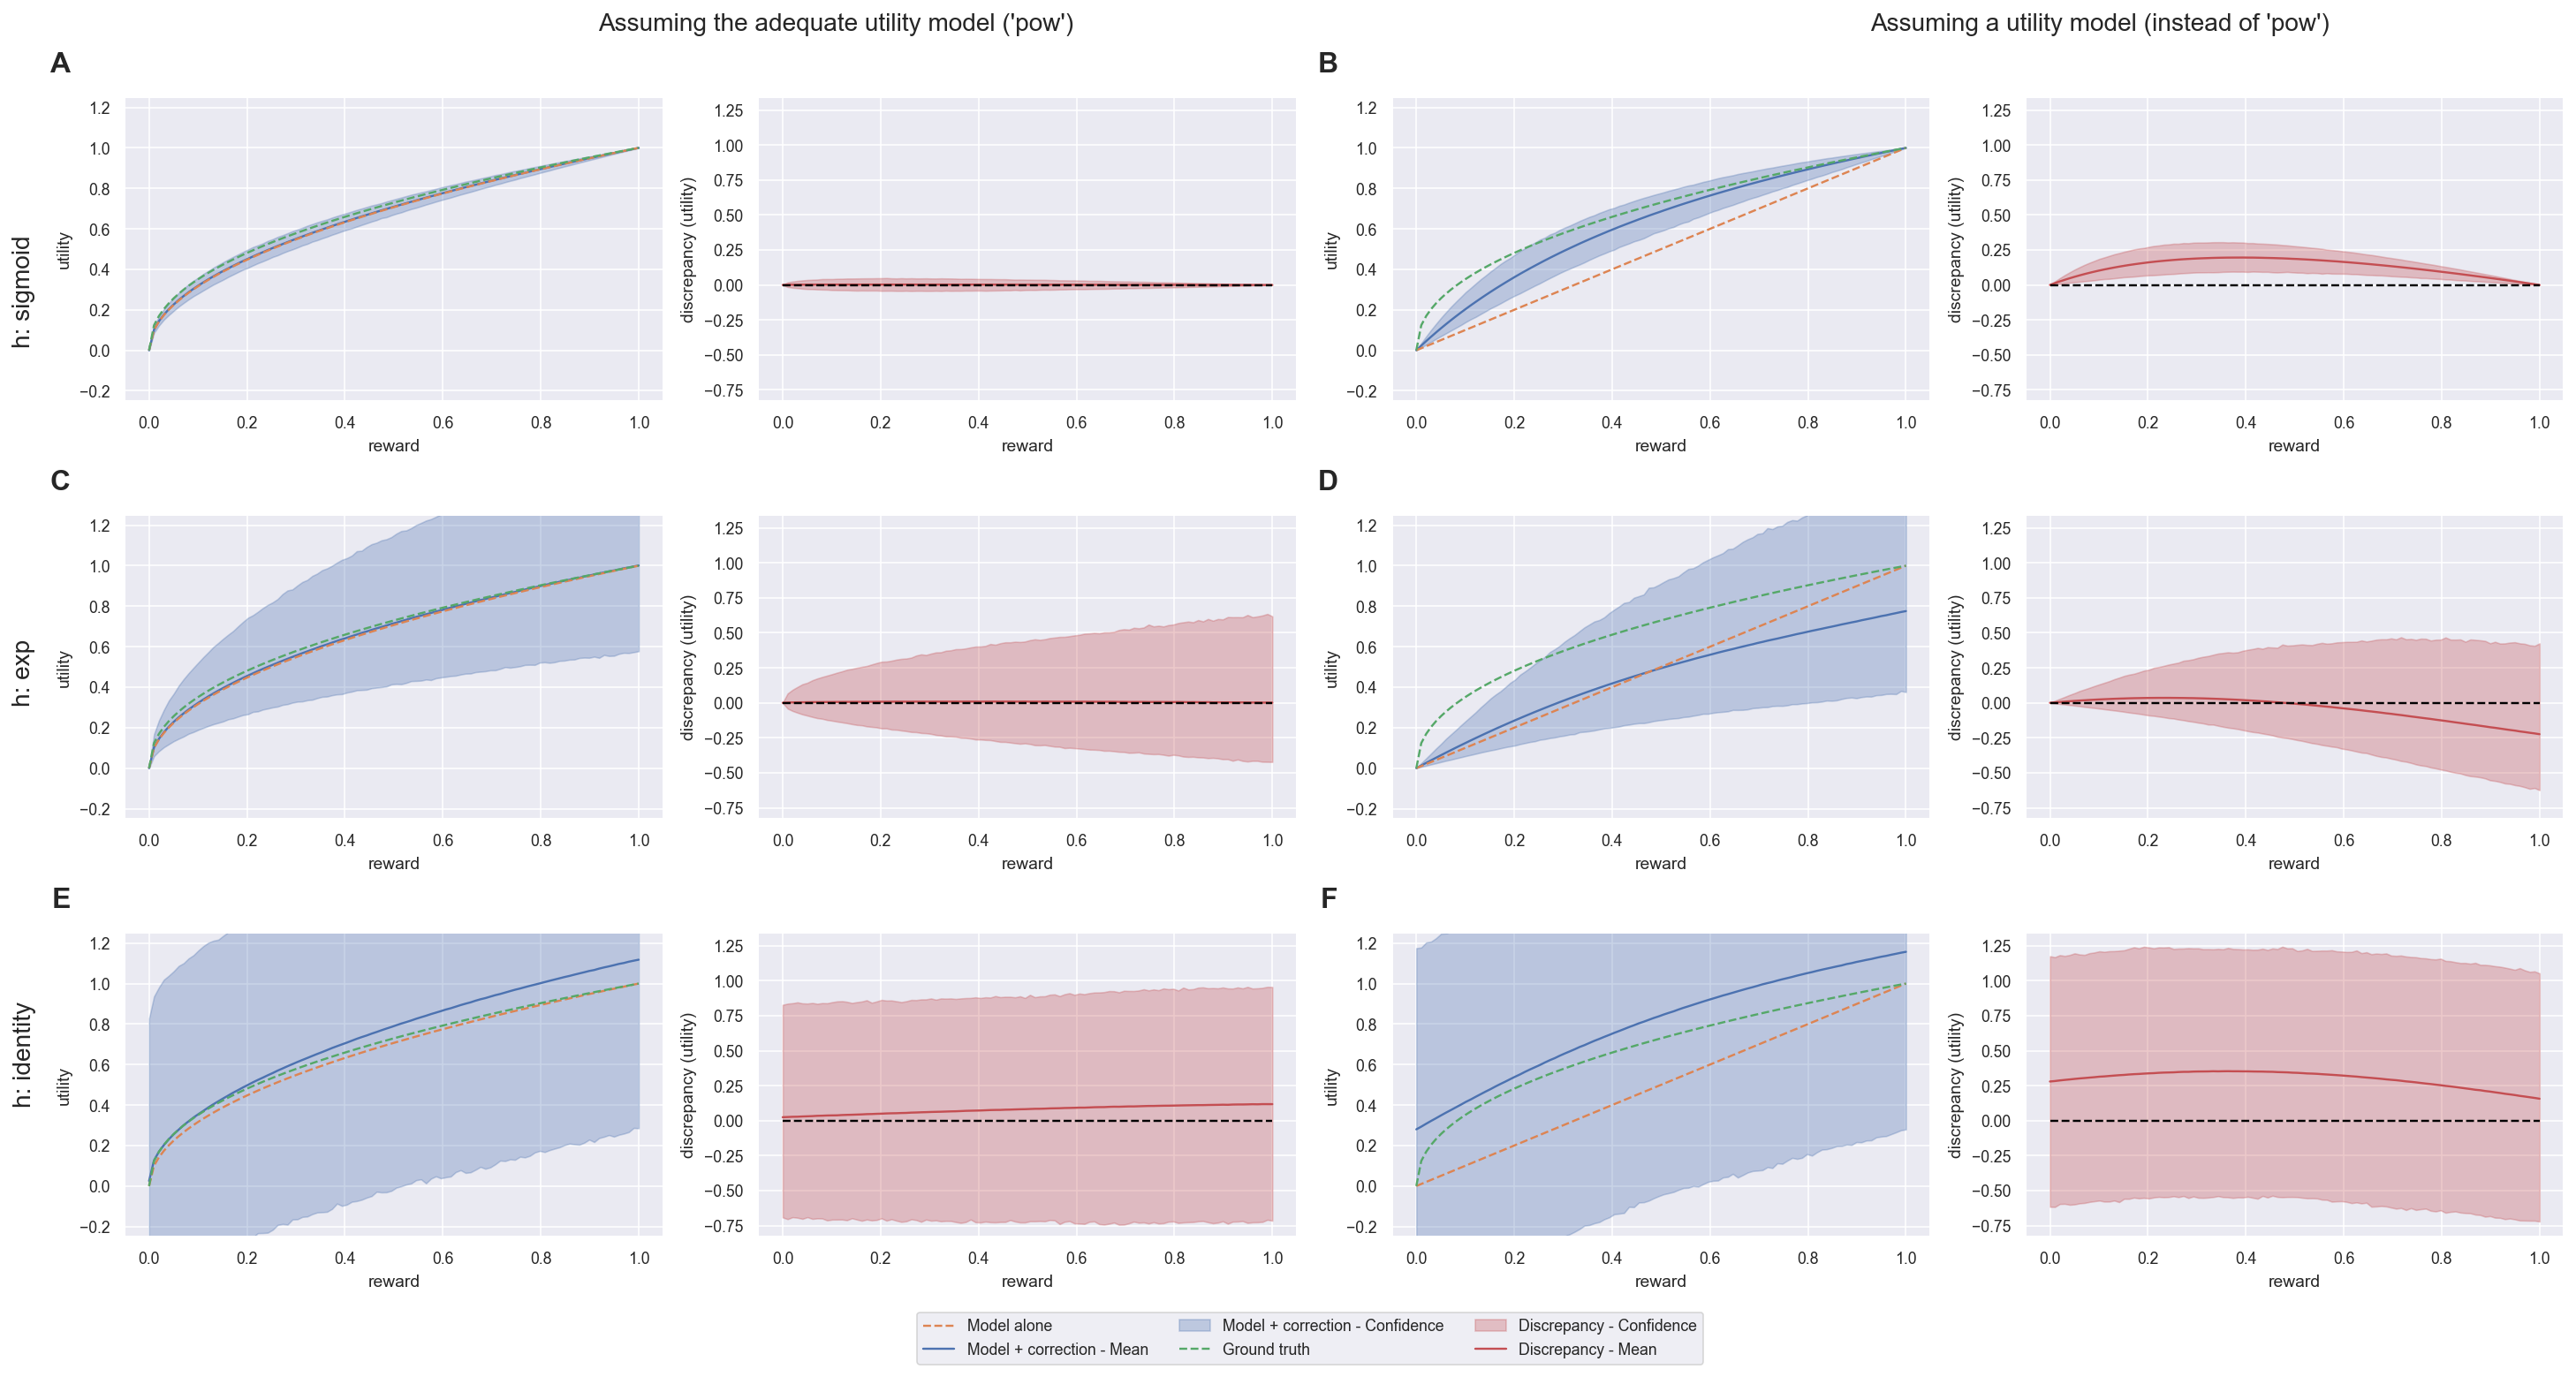

In [104]:
nrows = 3
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

err_max = - np.inf
err_min = np.inf

letter_idx = 0
letters = 'A', 'B', 'C', 'D', 'E', 'F'

for h_idx, h in enumerate(h_set):
    
    row_idx = h_idx

    for u_idx, u in enumerate(u_set):
        
        col_idx = u_idx * 2
        
        dm = discrepancy_models[(u.__name__, h)]

        fill_alpha = 0.3

        test_x = torch.linspace(0, 1, 100)
        m_pred, f_pred = dm.pred(test_x)

        test_x = test_x.numpy()
        m_pred = m_pred.numpy()
        f_pred = f_pred.numpy()
        
        truth = u_model(test_x, theta)

        f_mean = f_pred.mean(axis=0)
        lower, upper = np.percentile(f_pred, [2.5, 97.5], axis=0)

        ax0, ax1 = axes[row_idx, col_idx:col_idx+2]
        
        ax = ax0
        
        ax.text(-0.1, 1.15, letters[letter_idx], transform=ax.transAxes, fontsize=16, 
                fontweight='bold', va='top', ha='right')
        letter_idx += 1
        
        # GP confidence
        h_conf = ax.fill_between(test_x, upper, lower, color='C0', alpha=fill_alpha, label="Model + correction - Confidence")

        # GP mean
        h_mean, = ax.plot(test_x, f_mean, label="Model + correction - Mean")

        # Model
        h_model, = ax.plot(test_x, m_pred, color='C1', ls="--", label="Model alone")
        
        # Ground truth
        h_truth, = ax.plot(test_x, truth, color='C2', ls="--", label="Ground truth")

        ax.set_xlabel("reward")
        ax.set_ylabel("utility")

        # ax.legend(handles=[h_model, h_mean, h_conf])

        ax = ax1

        corr = f_mean - m_pred 
        corr_lower = lower - m_pred
        corr_upper = upper - m_pred

        # Error confidence
        corr_conf = ax.fill_between(test_x, corr_upper, corr_lower, 
                                    color='C3', alpha=fill_alpha, 
                                 label="Discrepancy - Confidence")

        # Error mean
        corr_mean, = ax.plot(test_x, corr, 
                             color="C3",
                             label="Discrepancy - Mean")

        # Baseline
        ax.plot(test_x, torch.zeros(m_pred.shape[0]), color='black', ls="--")

        ax.set_xlabel("reward")
        ax.set_ylabel("discrepancy (utility)")
        
        y_lim = ax.get_ylim()
        err_min = min(err_min, y_lim[0])
        err_max = max(err_max, y_lim[1])
        
fig.legend(handles=[h_model, h_mean, h_conf, h_truth, corr_conf, corr_mean], 
           bbox_to_anchor=(0.5,-0.05), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=3)

for axes_ in axes[:, 1::2]:
    for ax in axes_:
        ax.set_ylim(err_min, err_max)
        
for axes_ in axes[:, 0::2]:
    for ax in axes_:
        ax.set_ylim(-0.25, 1.25)

fig.text(0.22, 1.01, "Assuming the adequate utility model ('pow')", fontsize=14, transform=fig.transFigure, 
        verticalalignment='center')

fig.text(0.72, 1.01, "Assuming a utility model (instead of 'pow')", fontsize=14, transform=fig.transFigure, 
        verticalalignment='center')

fig.text(-0.01, 0.8, "h: sigmoid", fontsize=14, transform=fig.transFigure, 
        verticalalignment='center', rotation=90)

fig.text(-0.01, 0.5, "h: exp", fontsize=14, transform=fig.transFigure, 
        verticalalignment='center', rotation=90)

fig.text(-0.01, 0.2, "h: identity", fontsize=14, transform=fig.transFigure, 
        verticalalignment='center', rotation=90)

fig.tight_layout()

In [83]:
np.arange(4)[::2]

array([0, 2])